In [11]:
%cd /cluster/project/beltrao/jjaenes/23.03_DHODH
from workflow.modules import *

/cluster/project/beltrao/jjaenes/23.03_DHODH


In [12]:
import sklearn as sk, sklearn.preprocessing, sklearn.metrics

library_id = [
    'dude_actives',
    'dude_decoys_a',
    'dude_decoys_b',
    'dude_decoys_c',
    'dude_decoys_d',
    'dude_decoys_e',
    'dude_decoys_f',
    'dude_decoys_g',
    'dude_decoys_h',
    'dude_decoys_i',
    'dude_decoys_j',
    'prestwick_a',
    'prestwick_b',
    'prestwick_c',
]

In [13]:
'''
def read_diffdock(library_id, pdb_id):
    score_col_ = f'docking_score_{pdb_id}'
    fp_ = f'results/DiffDockRescore/{library_id}+{pdb_id}.tsv'
    #df_ = read_gnina(fp_).query('mode_id == 1')[['ligand_id', 'minimizedAffinity']].rename({'minimizedAffinity': score_col_}, axis=1)
    df_ = pd.read_csv(fp_, sep='\t').rename({'CNN_VS': score_col_}, axis=1)
    df_['ligand_id'] = df_['complex_name'].str.removesuffix(f'+{pdb_id}')
    df_['library_id'] = library_id
    df_[score_col_] = df_[score_col_].fillna(0)
    return df_.drop_duplicates(subset=['ligand_id'], keep=False)[['ligand_id', 'library_id', score_col_]]

method_name_ = 'DiffDock'
df_ = pd.concat([
    pd.concat(map(lambda l: read_diffdock(l, '1d3g'), library_id), axis=0).set_index(['ligand_id', 'library_id']),
    pd.concat(map(lambda l: read_diffdock(l, '1d3h'), library_id), axis=0).set_index(['ligand_id', 'library_id']),
    pd.concat(map(lambda l: read_diffdock(l, '4igh'), library_id), axis=0).set_index(['ligand_id', 'library_id']),
    pd.concat(map(lambda l: read_diffdock(l, '6j3c'), library_id), axis=0).set_index(['ligand_id', 'library_id']),
], axis=1).reset_index()
'''
def read_smina(library_id, pdb_id):
    score_col_ = f'docking_score_{pdb_id}'
    fp_ = f'results/smina/{library_id}+{pdb_id}.sdf'
    df_ = read_gnina(fp_).query('mode_id == 1')[['ligand_id', 'minimizedAffinity']].rename({'minimizedAffinity': score_col_}, axis=1)
    df_[score_col_] = -df_[score_col_]
    df_['library_id'] = library_id
    return df_

method_name_ = 'vina'
df_ = pd.concat([
    pd.concat(map(lambda l: read_smina(l, '1d3g'), library_id), axis=0).set_index(['ligand_id', 'library_id']),
    pd.concat(map(lambda l: read_smina(l, '1d3h'), library_id), axis=0).set_index(['ligand_id', 'library_id']),
    pd.concat(map(lambda l: read_smina(l, '4igh'), library_id), axis=0).set_index(['ligand_id', 'library_id']),
    pd.concat(map(lambda l: read_smina(l, '6j3c'), library_id), axis=0).set_index(['ligand_id', 'library_id']),
], axis=1).reset_index()


In [14]:
def label_id_(r):
    if r['library_id'] == 'dude_actives':
        return 'DUDE actives'
    elif r['library_id'].startswith('dude_decoys'):
        return 'DUDE decoys'
    elif r['library_id'].startswith('prestwick'):
        if r.ligand_id in {'teriflunomide', 'tiratricol', 'dicumarol'}:
            return 'in_vitro_active'
        elif r.ligand_id in {'leflunomide', 'azaribine', 'tegaserod_maleate', 'flunarizine_dihydrochloride', 'felodipine', 'cisatracurium_besylate', 'mesoridazine_besylate', 'amethopterin'}:
            return 'in_vitro_inactive'
        else:
            return 'Prestwick'
    else:
        return 'Unknown'

df_['label_id'] = df_.apply(label_id_, axis=1)
print(df_['label_id'].value_counts())

label_id
DUDE decoys          6446
Prestwick            1481
DUDE actives          111
in_vitro_inactive       8
in_vitro_active         3
Name: count, dtype: int64


In [15]:
for pdb_id in ['1d3g', '1d3h', '4igh', '6j3c']:
    score_col_ = f'docking_score_{pdb_id}'
    scaler_ = sklearn.preprocessing.RobustScaler().fit(df_.query('label_id == "Prestwick"')[score_col_].to_numpy().reshape(-1, 1))
    df_[score_col_] = scaler_.transform(df_[score_col_].to_numpy().reshape(-1, 1))
df_

,ligand_id,library_id,docking_score_1d3g,docking_score_1d3h,docking_score_4igh,docking_score_6j3c,label_id
0,CHEMBL199361,dude_actives,1.751009,1.030537,1.302090,1.559105,DUDE actives
1,CHEMBL39448,dude_actives,2.766514,1.564743,1.769770,1.746479,DUDE actives
2,CHEMBL202431,dude_actives,2.053976,1.591028,1.614369,1.508360,DUDE actives
3,CHEMBL200699,dude_actives,1.688564,1.270587,1.135574,1.371659,DUDE actives
4,CHEMBL356115,dude_actives,0.718278,0.500701,0.473524,0.665851,DUDE actives
...,...,...,...,...,...,...,...
8044,estradiol_valerate,prestwick_c,0.391612,0.616226,0.255896,1.085478,Prestwick
8045,sertaconazole_nitrate,prestwick_c,0.625008,0.890789,0.898255,0.753922,Prestwick
8046,thiethylperazine_maleate,prestwick_c,-0.311508,-0.000535,0.255819,0.237270,Prestwick
8047,verteporfin,prestwick_c,-12.225700,-8.619712,-3.676997,-6.615325,Prestwick


In [16]:
cols_ = [f'docking_score_{pdb_id}' for pdb_id in ['1d3g', '1d3h', '4igh', '6j3c'] ]
df_['docking_score_combined'] = df_[cols_].mean(axis=1)

#scaler_ = sklearn.preprocessing.RobustScaler().fit(df_.query('label_id == "Prestwick"')['docking_score_combined'].to_numpy().reshape(-1, 1))
#df_['docking_score_combined'] = scaler_.transform(df_['docking_score_combined'].to_numpy().reshape(-1, 1))

0.8458363731401274


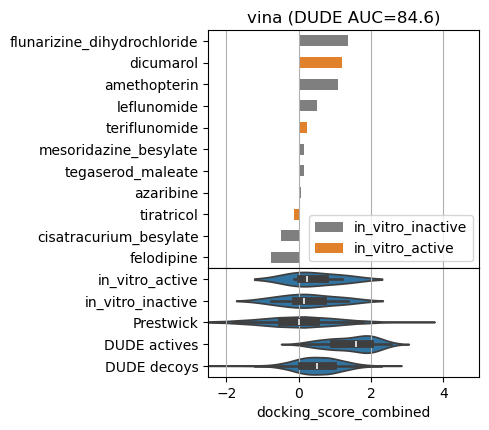

In [17]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3.5,4.5), gridspec_kw={'height_ratios': [11, 5]})
fig.subplots_adjust(hspace=0)

kwargs_ = {
    'palette': {
        'in_vitro_active': 'tab:orange',
        'in_vitro_inactive': 'tab:gray',
    }
}

df_invitro_ = df_.query('label_id == "in_vitro_inactive" | label_id == "in_vitro_active"').sort_values('docking_score_combined', ascending=False)
sns.barplot(data=df_invitro_, x='docking_score_combined', y='ligand_id', hue='label_id', width=.5, ax=ax[0], **kwargs_)
ax[0].legend(loc='lower right')

kwargs_ = {
    'order': [
        'in_vitro_active',
        'in_vitro_inactive',
        'Prestwick',
        'DUDE actives',
        'DUDE decoys',
    ],
    'orient': 'h',
    #'inner': 'stick',
    #'cut': 0,
}
sns.violinplot(data=df_, x='docking_score_combined', y='label_id', **kwargs_)
ax[0].set_xlim([-2.5, 5])
ax[0].xaxis.grid(True)
ax[1].xaxis.grid(True)
ax[0].set_ylabel('')
ax[1].set_ylabel('')

df_auc_ = df_.query('label_id == "DUDE actives" | label_id == "DUDE decoys"')
auc_ = sk.metrics.roc_auc_score(y_true=df_auc_['label_id'] == 'DUDE actives', y_score=df_auc_['docking_score_combined'])
print(auc_)
ax[0].set_title(f'{method_name_} (DUDE AUC={100*auc_:.1f})')
plt.savefig(f'results/scoreplot_{method_name_}.svg', bbox_inches='tight', transparent=True)

In [18]:
#df_.to_csv(f'results/docking_scores_{method_name_}.tsv', index=False, header=True, sep='\t')

In [19]:
#q_ = 'label_id == "Prestwick" | label_id == "in_vitro_active" | label_id == "in_vitro_inactive"'
#df1_ = pd.read_csv('results/docking_scores_DiffDock.tsv', sep='\t').query(q_)[['ligand_id', 'docking_score_combined', 'label_id']]\
#    .rename({'docking_score_combined': 'docking_score_diffdock'}, axis=1)
#df2_ = pd.read_csv('results/docking_scores_vina.tsv', sep='\t').query(q_)[['ligand_id', 'docking_score_combined']]\
#    .rename({'docking_score_combined': 'docking_score_vina'}, axis=1)

In [20]:
#df_table_ = df1_.merge(df2_, on='ligand_id')[['ligand_id', 'label_id', 'docking_score_vina', 'docking_score_diffdock']]\
#    .sort_values('docking_score_diffdock', ascending=False)
#df_table_.drop_duplicates(keep='first').to_csv('results/docking_scores.tsv', sep='\t', index=False, header=True)